# Politician Sentiment Analysis - Classification

Name:       Devin Patel  
Class:      CS 588 - 01  
Term:       FA 22  
Project:    Determining party alignment based on 2016 Election tweets.  
File Purpose: To gauge various classifier accuracies on selected features.

## Initialization

In [1]:
# Imports
import numpy as np
import pandas as pd
import scipy.io
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest       # ANOVA
from sklearn.feature_selection import f_regression      # ANOVA
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split    # Splits sample set into train/test sets

from sklearn.naive_bayes import GaussianNB              # Gaussian Naive Bayes
from sklearn.svm import SVC                             # SVM
from sklearn.neural_network import MLPClassifier        # CNN
from sklearn.pipeline import Pipeline                   # For estimating classifier models

import os                                               # For exporting figures


# Paths and Constants
twitter_data_path = r"Data/TweetData.pkl"
RANDOM_STATE = 12
KEPT_FEATURES = 2
NORM_RANGE = (0, 1)


In [2]:
# Exports pyplot figure
import os

def exportFig(fname):
    exportPath = r"Figures/classifiers"

    try:
        if not os.path.exists(exportPath): os.mkdir(exportPath)
    except Exception:
        print("Can't create a directory to store figures, so they will not be saved.")
        return
    
    exportPath = os.path.join(exportPath, fname)
    
    plt.savefig(exportPath)

In [3]:
# Plot function for a classifier
def plot_learning_curve(classifier, X, y, tsizes=np.linspace(0.1, 0.5, 5), label="", color='r', axes=None):
    estimator = Pipeline([("scaler", MinMaxScaler()), ('classifier', classifier)])
    #x_train, x_test, y_train, y_test = train_test_split(iris_x, iris_target, train_size=0.9, random_state=RANDOM_STATE, shuffle=True)
    
    train_scores = []
    test_scores = []
    train_sizes = []
    
    # tsizes are the training sizes [0.1, 0.2, 0.3, 0.4, 0.5]
    for tsize in tsizes:
        tsize_i = tsize*100
        x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=tsize, random_state=RANDOM_STATE, shuffle=True)
        estimator.fit(x_train, y_train)
        train_scores.append(estimator.score(x_train, y_train) * 100)
        test_scores.append(estimator.score(x_test, y_test) * 100)
        train_sizes.append(tsize_i)
    
    if axes is None:
        _, axes = plt.subplot(2)
    
    #axes[0].errorbar(train_sizes, test_scores_mean, yerr=test_scores_std, capsize=5, color=color, label=label)
    axes[0].plot(train_sizes, test_scores, "o-", color=color, label=label)
    axes[1].plot(train_sizes, train_scores, "o-", color=color, label=label)
    
    print(f"Training Accuracy of {label}: {train_scores[-1]}%")
    print(f"Testing Accuracy of {label}: {test_scores[-1]}%")
    print()
    
    return plt

In [4]:
# Loading data from pkl file
X_df = pd.read_pickle(twitter_data_path, compression='infer')

# Separate ground truth from dataframe.
party_gth_df = pd.DataFrame(X_df.pop('Party'))

# Create class labels list for both ground truth dataframes
party_gth_labels = ["R", "D"] # Based on preprocessing: 0 = Republican, 1 = Democrat

# Create feature labels list
feature_labels = X_df.columns.values.tolist()

scaler_model = MinMaxScaler(feature_range=NORM_RANGE)
scaler_model.fit(X_df)
X = scaler_model.transform(X_df)
X_df = pd.DataFrame(X, columns=feature_labels)

X_subject_df = pd.concat([X_df['Likes'], X_df['Retweets'], X_df['Subjectivity']], axis=1)
X_polar_df = pd.concat([X_df['Likes'], X_df['Retweets'], X_df['Polarity']], axis=1)

X_subject = X_subject_df.to_numpy()
X_polar = X_polar_df.to_numpy()

# Data is ready
print(f"\nShape of main dataframe: {X_df.shape}")



Shape of main dataframe: (65952, 4)


In [5]:
# Initialize feature selection here

# PCA
PCA_KEPT_COMPONENTS = KEPT_FEATURES # Max 4

# Polarity removed
pca = PCA(n_components=PCA_KEPT_COMPONENTS, random_state=RANDOM_STATE)
X_r_subject = pca.fit_transform(X_subject)

# Subjectivity removed
X_r_polar = pca.fit_transform(X_polar)


# LDA
LDA_KEPT_COMPONENTS = 1 # Max 1 because 2 parties
lda = LDA(n_components=LDA_KEPT_COMPONENTS)

X_r2 = lda.fit_transform(X, party_gth_df["Party"])
X_r2_subject = lda.fit_transform(X_subject, party_gth_df['Party'])
X_r2_polar = lda.fit_transform(X_polar, party_gth_df['Party'])


# ANOVA
ANOVA_KEPT_COMPONENTS = KEPT_FEATURES
fs = SelectKBest(score_func=f_regression, k=ANOVA_KEPT_COMPONENTS)

X_r3 = fs.fit_transform(X, party_gth_df['Party'])
X_r3_subject = fs.fit_transform(X_subject, party_gth_df['Party'])
X_r3_polar = fs.fit_transform(X_polar, party_gth_df['Party'])


## Classification Accuracies

In [6]:
# Initialize Classifiers
CNN_LAYERS = (150, 125, 100, 75, 50)
MAX_ITER = 500

# Create a list of classifier models
models = [('NB', GaussianNB()) # Naive Bayes
          ,('SVM (RBF)', SVC(kernel='rbf', gamma='auto', random_state=RANDOM_STATE)) # SVM - RBF
          ,('CNN (MLP)', MLPClassifier(hidden_layer_sizes=CNN_LAYERS, max_iter=MAX_ITER,
                                       activation='relu', solver='adam', random_state=RANDOM_STATE)) # CNN
          ]

MAX_TRAIN_SIZE = 0.5

classifier_labels = {"Gaussian Naive Bayes": (models[0][1], "green")
                    ,"SVM - RBF": (models[1][1], "blue")
                    ,"CNN - MLP": (models[2][1] ,"red")
                    }

### PCA

Training Accuracy of Gaussian Naive Bayes: 52.46846191169335%
Testing Accuracy of Gaussian Naive Bayes: 51.94687045123726%

Training Accuracy of SVM - RBF: 53.787603105288696%
Testing Accuracy of SVM - RBF: 53.5965550703542%

Training Accuracy of CNN - MLP: 64.86232411450752%
Testing Accuracy of CNN - MLP: 65.02001455604076%



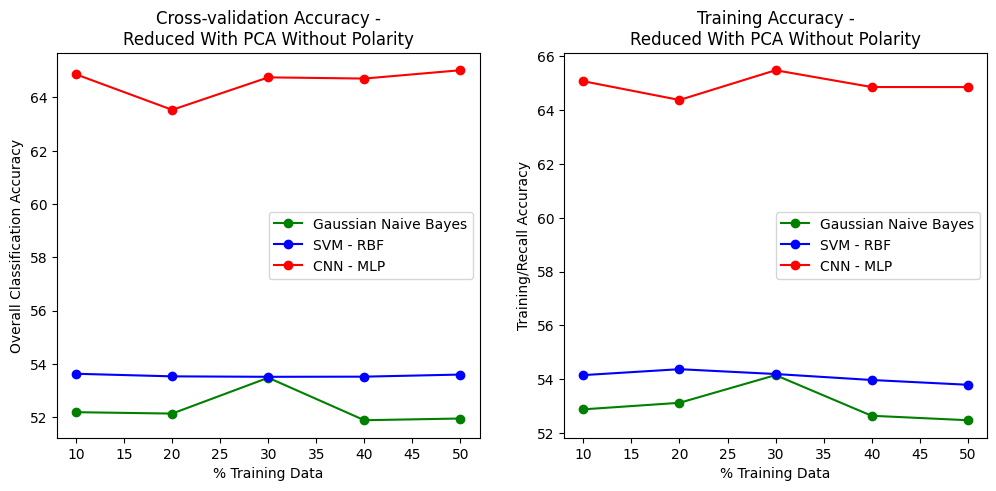

In [8]:
# Creates plots for subjectivity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r_subject, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With PCA Without Polarity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With PCA Without Polarity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Subject-PCA.png")

plt.show()

In [ ]:
# Creates plots for polarity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r_polar, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With PCA Without Subjectivity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With PCA Without Subjectivity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Polar-PCA.png")

plt.show()

### LDA

In [ ]:
# Creates plots for subjectivity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r2_subject, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With LDA Without Polarity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With LDA Without Polarity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Subject-LDA.png")

plt.show()

In [ ]:
# Creates plots for polarity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r2_polar, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With LDA Without Subjectivity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With LDA Without Subjectivity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Polar-LDA.png")

plt.show()

### ANOVA

In [ ]:
# Creates plots for subjectivity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r3_subject, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With ANOVA Without Polarity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With ANOVA Without Polarity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Subject-ANOVA.png")

plt.show()

In [ ]:
# Creates plots for polarity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r3_polar, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With ANOVA Without Subjectivity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With ANOVA Without Subjectivity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Polar-ANOVA.png")

plt.show()